In [1]:
%matplotlib inline

In [2]:
import roms_tools as rt
from pathlib import Path
import datetime as dt
from dask.diagnostics import ProgressBar
rt.__version__

'2.2.0'

In [3]:
outdir = Path("input_datasets_netcdf")
partdir = Path("input_netcdf_parted")
yamldir = Path("input_datasets_yaml")


start_time = dt.datetime(2012, 1, 1, 0, 0, 0)
end_time   = dt.datetime(2012, 2, 1, 0, 0, 0)

In [4]:
import os
if os.environ.get("LMOD_SYSHOST") == "perlmutter":
    glorys_datadir = "/global/cfs/projectd/global/cfs/projectdirs/m4746/Datasets/alpha/ERA5/NA/2012/irs/m4746/Datasets/alpha/GLORYS/NA/2012/"
    era5_datadir = "/global/cfs/projectdirs/m4746/Datasets/alpha/ERA5/NA/2012/"
    cesm_datadir = "/global/cfs/projectdirs/m4746/Datasets/alpha/CESM_REGRIDDED/"
    tpxo_datadir = "/global/cfs/projectdirs/m4746/Datasets/alpha/TPXO/"
else: # If you're not on perlmutter, we'll assume you've put your roms-tools datasets in ~/Code/roms_tools_datasets:
    datadir = Path("~/Code/roms_tools_datasets").expanduser()
    glorys_datadir = datadir
    era5_datadir = datadir
    cesm_datadir = datadir
    tpxo_datadir = datadir

In [5]:
rm {outdir}/*.nc

In [6]:
rm {partdir}/*.nc

In [7]:
rm {yamldir}/*.yaml

In [8]:
NP_XI = 3
NP_ETA = 3

In [9]:
%%bash
du -sLch ~/Code/roms_tools_datasets

 39G	/Users/dafyddstephenson/Code/roms_tools_datasets
 39G	total


# Make grid

[PosixPath('input_netcdf_parted/roms_grd.0.nc'),
 PosixPath('input_netcdf_parted/roms_grd.1.nc'),
 PosixPath('input_netcdf_parted/roms_grd.2.nc'),
 PosixPath('input_netcdf_parted/roms_grd.3.nc'),
 PosixPath('input_netcdf_parted/roms_grd.4.nc'),
 PosixPath('input_netcdf_parted/roms_grd.5.nc'),
 PosixPath('input_netcdf_parted/roms_grd.6.nc'),
 PosixPath('input_netcdf_parted/roms_grd.7.nc'),
 PosixPath('input_netcdf_parted/roms_grd.8.nc')]

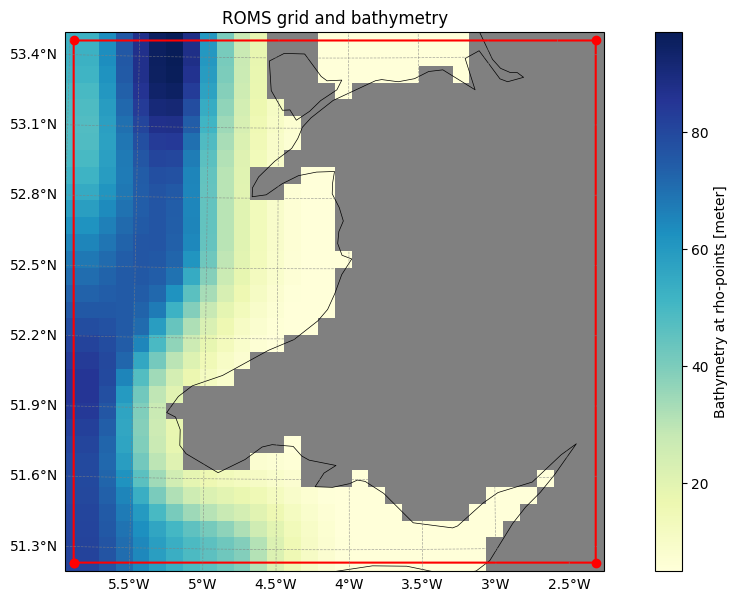

In [10]:
roms_grd = rt.Grid(nx=30,
                   ny = 30,
                   size_x = 240,
                   size_y = 240,
                   N = 20,
                   rot = 0,
                   center_lon = -4.1,
                   center_lat = 52.36)

roms_grd.plot(bathymetry=True)
roms_grd.to_yaml(yamldir/"roms_grd.yaml")

# Save non-partitioned ouput
roms_grd.save(outdir /"roms_grd")
roms_grd.save(outdir /"roms_grd")

# Save partitioned output
roms_grd.save(partdir /"roms_grd", np_xi=NP_XI, np_eta=NP_ETA)
roms_grd.save(partdir /"roms_grd", np_xi=NP_XI, np_eta=NP_ETA)

In [11]:
roms_grd

Grid(nx=30, ny=30, size_x=240, size_y=240, center_lon=-4.1, center_lat=52.36, rot=0, N=20, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=False, straddle=False)

# Make tides

[PosixPath('input_netcdf_parted/roms_tides.0.nc'),
 PosixPath('input_netcdf_parted/roms_tides.1.nc'),
 PosixPath('input_netcdf_parted/roms_tides.2.nc'),
 PosixPath('input_netcdf_parted/roms_tides.3.nc'),
 PosixPath('input_netcdf_parted/roms_tides.4.nc'),
 PosixPath('input_netcdf_parted/roms_tides.5.nc'),
 PosixPath('input_netcdf_parted/roms_tides.6.nc'),
 PosixPath('input_netcdf_parted/roms_tides.7.nc'),
 PosixPath('input_netcdf_parted/roms_tides.8.nc')]

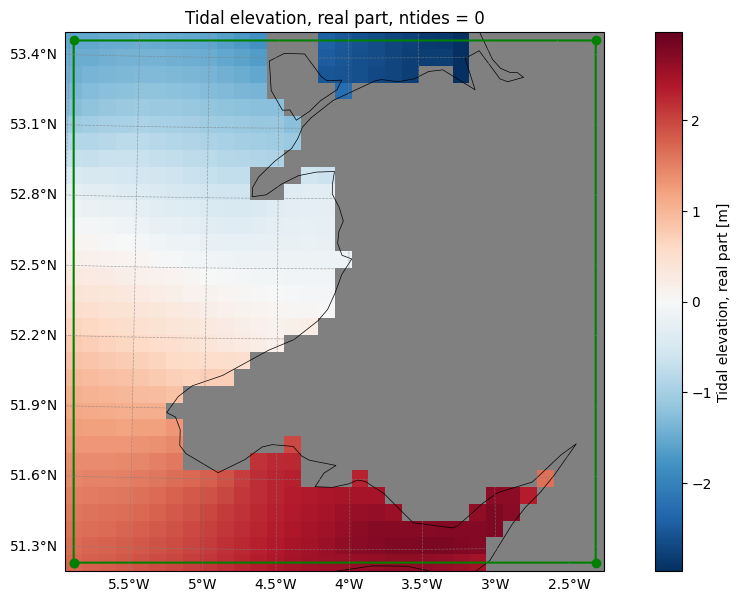

In [12]:
roms_tides = rt.TidalForcing(grid=roms_grd,
                             source = {'name':'TPXO','path': tpxo_datadir / 'tpxo9.v2a.nc'},
                             ntides = 14)
roms_tides.plot("ssh_Re", ntides=0)

# Save yaml
roms_tides.to_yaml(yamldir/"roms_tides.yaml")
# Save non-partitioned
roms_tides.save(outdir/'roms_tides.nc')
# Save partitioned
roms_tides.save(partdir/'roms_tides.nc',np_xi=NP_XI,np_eta=NP_ETA)

# Atmospheric forcing (physics)

In [13]:
# %%time
roms_frc = rt.SurfaceForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": era5_datadir/"ERA5_2012-01.nc"},
    correct_radiation=True,
    use_coarse_grid=False,
    type="physics",  # "physics" or "bgc"; default is "physics"
)

# Save yaml
roms_frc.to_yaml(yamldir/'roms_frc.yaml')
# Save non-partitioned
roms_frc.save(outdir/'roms_frc')
# Save partitioned
roms_frc.save(partdir/'roms_frc',np_xi=NP_XI,np_eta=NP_ETA)

# with ProgressBar():
#     %time roms_frc.save(outdir/'roms_frc')
# with ProgressBar():
#     %time roms_frc.save(outdir/'PARTED/roms_frc',np_xi=NP_XI,np_eta=NP_ETA)

WARNING - No records found at or after the end_time.


[PosixPath('input_netcdf_parted/roms_frc.0.nc'),
 PosixPath('input_netcdf_parted/roms_frc.1.nc'),
 PosixPath('input_netcdf_parted/roms_frc.2.nc'),
 PosixPath('input_netcdf_parted/roms_frc.3.nc'),
 PosixPath('input_netcdf_parted/roms_frc.4.nc'),
 PosixPath('input_netcdf_parted/roms_frc.5.nc'),
 PosixPath('input_netcdf_parted/roms_frc.6.nc'),
 PosixPath('input_netcdf_parted/roms_frc.7.nc'),
 PosixPath('input_netcdf_parted/roms_frc.8.nc')]

# Atmospheric forcing (BGC)

In [14]:
# %%time
roms_frc_bgc = rt.SurfaceForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_datadir/"CESM-surface_lowres_regridded.nc"},
    type="bgc",
)

# Save yaml
roms_frc_bgc.to_yaml(yamldir/'roms_frc_bgc.yaml')
# Save non-partitioned
roms_frc_bgc.save(filepath=outdir/'roms_frc_bgc')
# Save partitioned
roms_frc_bgc.save(filepath=partdir/'roms_frc_bgc',np_xi=NP_XI,np_eta=NP_ETA)

# with ProgressBar():
#     %time roms_frc_bgc.save(filepath=outdir/'roms_frc_bgc')
# with ProgressBar():
#     %time roms_frc_bgc.save(filepath=outdir/'PARTED/roms_frc_bgc',np_xi=NP_XI,np_eta=NP_ETA)

[PosixPath('input_netcdf_parted/roms_frc_bgc.0.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.1.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.2.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.3.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.4.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.5.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.6.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.7.nc'),
 PosixPath('input_netcdf_parted/roms_frc_bgc.8.nc')]

# Initial conditions

INFO - Selected time entry closest to the specified start_time (2012-01-01 00:00:00) within the range [2012-01-01 00:00:00, 2012-01-02 00:00:00]: ['2012-01-01T12:00:00.000000000']


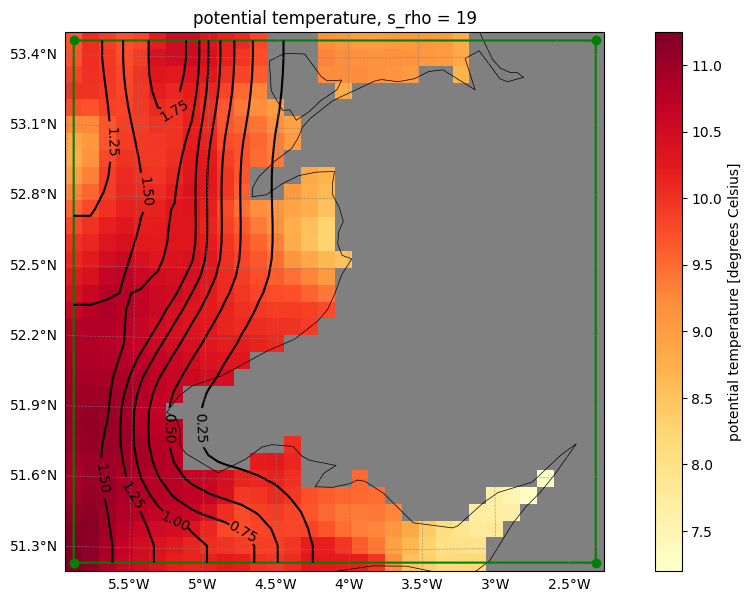

In [15]:
# %%time
ini_time=dt.datetime(2012,1,1)
roms_ini = rt.InitialConditions(
    grid=roms_grd,
    ini_time=ini_time,
    source={"name" : "GLORYS",
                    "path" : glorys_datadir/"GLORYS/mercatorglorys12v1_gl12_mean_20120101.nc"},
    bgc_source={"name": "CESM_REGRIDDED",
                "path": str(cesm_datadir/"CESM-climatology_lowres_regridded.nc"),
                "climatology": True,
    },
)
roms_ini.plot("temp", s=-1, depth_contours=True)

# Save yaml
roms_ini.to_yaml(yamldir/'roms_ini.yaml')
# Save partitioned
with ProgressBar():
    roms_ini.save(partdir/"roms_ini.nc",np_xi=NP_XI,np_eta=NP_ETA)
# Save non-partitioned
with ProgressBar():
    roms_ini.save(outdir/"roms_ini.nc")

# Boundary conditions

In [16]:
roms_bry = rt.BoundaryForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_datadir/"GLORYS/mercatorglorys*.nc"},
    apply_2d_horizontal_fill=True,
    boundaries = {
        "south": True,
        "east": False,
        "north": True,
        "west": True,
    },
    use_dask=True
)

# Save yaml
roms_bry.to_yaml(yamldir/"roms_bry.yaml")
# Save non-partitioned
with ProgressBar():
    roms_bry.save(f"{outdir}/roms_bry") #no .nc again
# Save partitioned
with ProgressBar():
    roms_bry.save(f"{partdir}/roms_bry",np_xi=NP_XI,np_eta=NP_ETA) #no .nc again


WARNING - No records found at or before the start_time.
WARNING - No records found at or after the end_time.


[########################################] | 100% Completed | 17.20 s
[########################################] | 100% Completed | 17.26 s


In [17]:

roms_bry_bgc = rt.BoundaryForcing(
    grid = roms_grd,
    start_time = start_time,
    end_time = end_time,
    source={"name": "CESM_REGRIDDED", 
            "path": cesm_datadir/"CESM-climatology_lowres_regridded.nc", 
            "climatology": True},
    type="bgc",
    apply_2d_horizontal_fill=True,
    boundaries = {
        "south": True,
        "east": False,
        "north": True,
        "west": True,
    },
    use_dask=True    
)
# Save yaml
roms_bry_bgc.to_yaml(yamldir/"roms_bry_bgc.yaml")
# Save non-partitioned
with ProgressBar():
    %time roms_bry_bgc.save(f"{outdir}/roms_bry_bgc")
# Save partitioned
with ProgressBar():
    %time roms_bry_bgc.save(f"{partdir}/roms_bry_bgc",np_xi=NP_XI,np_eta=NP_ETA) #no .nc again

[########################################] | 100% Completed | 23.38 ss
[########################################] | 100% Completed | 23.43 s
CPU times: user 21.6 s, sys: 14.1 s, total: 35.7 s
Wall time: 23.9 s
CPU times: user 360 ms, sys: 55 ms, total: 415 ms
Wall time: 422 ms


# River forcing

In [18]:
roms_riv_frc = rt.RiverForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    convert_to_climatology="if_any_missing",  # "never", "always", or "if_any_missing" (default)
)


INFO - Compute climatology for river forcing.


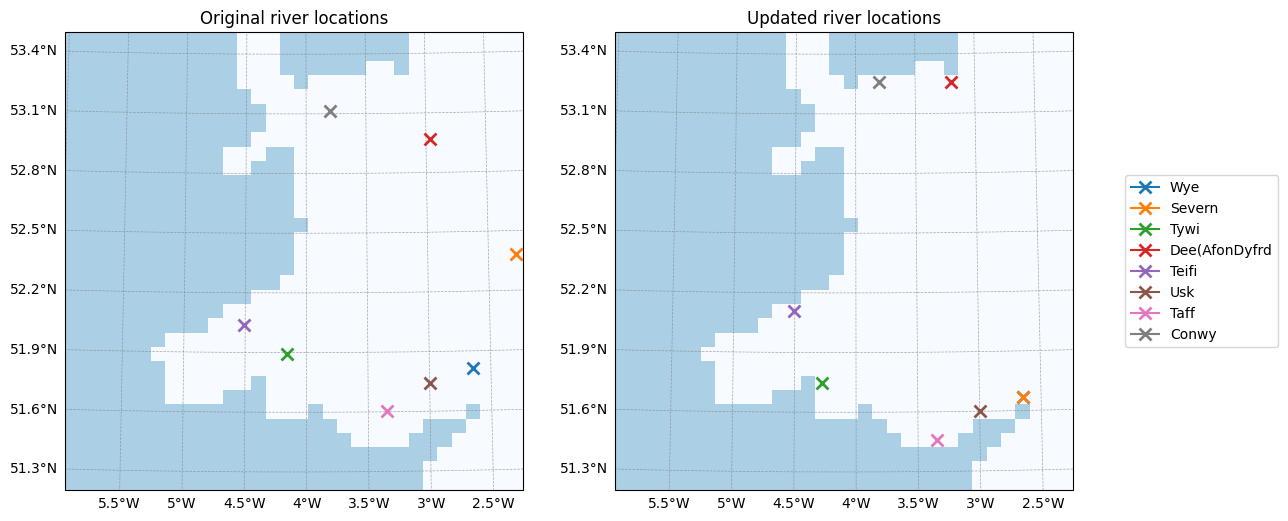

In [19]:
roms_riv_frc.plot_locations()

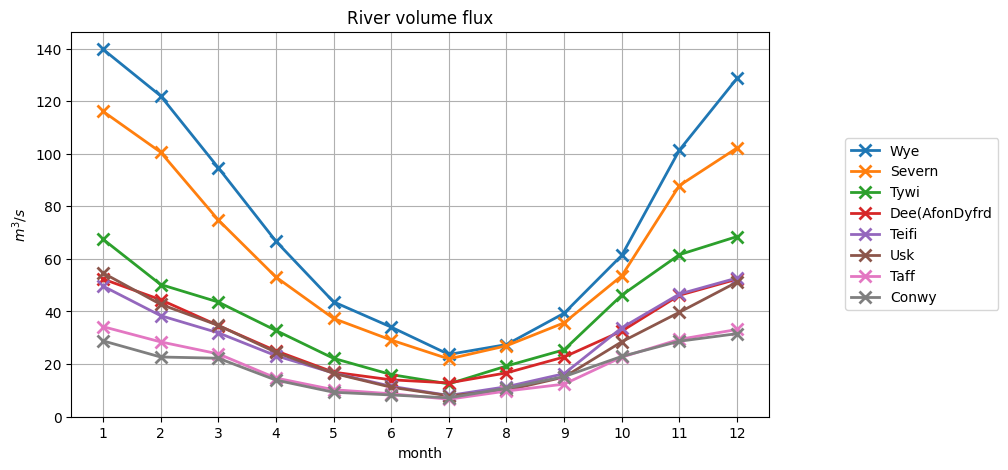

In [20]:
roms_riv_frc.plot("river_volume")

In [21]:
# Save yaml
roms_riv_frc.to_yaml(yamldir/"roms_riv_frc.yaml")
# Save non-partitioned
roms_riv_frc.save(filepath=outdir/"roms_riv_frc.nc", filepath_grid=outdir/"roms_grd.nc")
# Save partitioned
roms_riv_frc.save(filepath=partdir/"roms_riv_frc.nc", filepath_grid=partdir/"roms_grd.nc",np_xi=NP_XI,np_eta=NP_ETA)

[PosixPath('input_netcdf_parted/roms_riv_frc.0.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.1.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.2.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.3.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.4.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.5.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.6.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.7.nc'),
 PosixPath('input_netcdf_parted/roms_riv_frc.8.nc'),
 PosixPath('input_netcdf_parted/roms_grd.0.nc'),
 PosixPath('input_netcdf_parted/roms_grd.1.nc'),
 PosixPath('input_netcdf_parted/roms_grd.2.nc'),
 PosixPath('input_netcdf_parted/roms_grd.3.nc'),
 PosixPath('input_netcdf_parted/roms_grd.4.nc'),
 PosixPath('input_netcdf_parted/roms_grd.5.nc'),
 PosixPath('input_netcdf_parted/roms_grd.6.nc'),
 PosixPath('input_netcdf_parted/roms_grd.7.nc'),
 PosixPath('input_netcdf_parted/roms_grd.8.nc')]

---



# Make C-Star Case



---


In [22]:
code_location = "/Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example"
netcdf_dataset_location = Path("/Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_netcdf")
yaml_dataset_location = Path("/Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_yaml")

## BaseModel

In [23]:
from cstar.roms import ROMSBaseModel
from cstar.marbl import MARBLBaseModel

roms_base_model = ROMSBaseModel(
    source_repo='https://github.com/CESR-lab/ucla-roms.git',
    checkout_target="52adceac25670ee985d741d1bad62639dac3d183",
)

marbl_base_model = MARBLBaseModel(
    source_repo='https://github.com/marbl-ecosys/MARBL.git',
    checkout_target='marbl0.45.0'
)

## AdditionalCode

In [24]:

from cstar.base import AdditionalCode

roms_namelists = AdditionalCode(
    location = code_location,
    subdir = "roms_runtime_code",
    # checkout_target = "cstar_alpha",
    files = [
        "roms.in_TEMPLATE",
        "marbl_in",
        "marbl_tracer_output_list",
        "marbl_diagnostic_output_list"
    ]
)
print(roms_namelists)

AdditionalCode
--------------
Location: /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example
subdirectory: roms_runtime_code
Working path: None
Exists locally: False (get with AdditionalCode.get())
Files:
    roms.in_TEMPLATE      (roms.in will be used by C-Star based on this template)
    marbl_in
    marbl_tracer_output_list
    marbl_diagnostic_output_list


In [25]:
roms_additional_source_code = AdditionalCode(
    location = code_location,
    subdir = "roms_compile_time_code",
    # checkout_target = "cstar_alpha",
    files = [
        "bgc.opt",
         "bulk_frc.opt",
         "cppdefs.opt",
         "diagnostics.opt",
         "ocean_vars.opt",
         "param.opt",
         "tracers.opt",
         "Makefile",
         "Make.depend",
    ]
)

print(roms_additional_source_code)

AdditionalCode
--------------
Location: /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example
subdirectory: roms_compile_time_code
Working path: None
Exists locally: False (get with AdditionalCode.get())
Files:
    bgc.opt
    bulk_frc.opt
    cppdefs.opt
    diagnostics.opt
    ocean_vars.opt
    param.opt
    tracers.opt
    Makefile
    Make.depend


# InputDatasets (netcdf)

In [26]:
%%bash
cd /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_netcdf/
shasum -a 256 *.nc

6bb80cd0f62700ed4d08af3b7ae0aec0f88a2395f25c8e17b583d60bec00bae0  roms_bry.nc
d331b9d737a8d7a4840e32d6fb5c1e713c0f60e5c9dfc11f9081234d4b401a91  roms_bry_bgc.nc
b13cfa7d700b6ed4dcbdff5de6f7d94451fbbcf3e61a83d2beca5951198a4bc9  roms_frc.nc
1410737cfb5fe7856fc6ddd3304aa9d70ef2896ed6e33142b1a99472135f3cae  roms_frc_bgc.nc
0cded2da748803b50ac820b3b9d608b5987dc41b99a9d99a7c910a427c7f8a38  roms_grd.nc
5eb081996f24c1e16b94bb20b3d6222e27237ff6f9508ba4f58805133fd64e3f  roms_ini.nc
60cc745ba0a1054da652cbcb3485200d1a75b49b391d6d75679b18e94a2c369e  roms_riv_frc.nc
20f6ed9f35b181fb1125cafa29ecae6cab1590651a9bdc45415436c6a837e1ac  roms_tides.nc


In [27]:
from cstar.roms import ROMSModelGrid, ROMSInitialConditions, ROMSTidalForcing, ROMSBoundaryForcing, ROMSSurfaceForcing

# Boundary
roms_phys_boundary_forcing_nc = ROMSBoundaryForcing(
    location=netcdf_dataset_location/"roms_bry.nc",
    file_hash="6bb80cd0f62700ed4d08af3b7ae0aec0f88a2395f25c8e17b583d60bec00bae0",
)
roms_bgc_boundary_forcing_nc = ROMSBoundaryForcing(
    location = netcdf_dataset_location/"roms_bry_bgc.nc",
    file_hash = "d331b9d737a8d7a4840e32d6fb5c1e713c0f60e5c9dfc11f9081234d4b401a91",
)

# Surface
roms_phys_surface_forcing_nc = ROMSSurfaceForcing(
    location=netcdf_dataset_location/"roms_frc.nc",
    file_hash="b13cfa7d700b6ed4dcbdff5de6f7d94451fbbcf3e61a83d2beca5951198a4bc9",
)
roms_bgc_surface_forcing_nc = ROMSSurfaceForcing(
    location=netcdf_dataset_location/"roms_frc_bgc.nc",
    file_hash="1410737cfb5fe7856fc6ddd3304aa9d70ef2896ed6e33142b1a99472135f3cae",
)

#Grid
roms_model_grid_nc = ROMSModelGrid(
    location=netcdf_dataset_location/"roms_grd.nc",
    file_hash="0cded2da748803b50ac820b3b9d608b5987dc41b99a9d99a7c910a427c7f8a38",
)

# Initial conditions
roms_initial_conditions_nc = ROMSInitialConditions(
    location=netcdf_dataset_location/"roms_ini.nc",
    file_hash="5eb081996f24c1e16b94bb20b3d6222e27237ff6f9508ba4f58805133fd64e3f",
)

# Tides
roms_tidal_forcing_nc = ROMSTidalForcing(
    location=netcdf_dataset_location/"roms_tides.nc",
    file_hash="20f6ed9f35b181fb1125cafa29ecae6cab1590651a9bdc45415436c6a837e1ac",
)



# InputDatasets (yaml)

In [41]:
%%bash
cd /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_yaml/
shasum -a 256 *.yaml

8fcc90cb36b549ea40f60f2021449ad5ae13299002aa3331b70e3a7e91914036  roms_bry.yaml
3cf3fe3afcf2c3357b7662090b5ccde7d84702693a6a178e9042fc7377d1a5af  roms_bry_bgc.yaml
6bbaa92bfc13c446f42e777310d020dec1bd335f33fe752dea155f1219d18411  roms_frc.yaml
a861dfb56ceebea0353b969a40b7ca3ed7e7bf49bcdb56d35adc477f9a727194  roms_frc_bgc.yaml
2cbb93a6317e74a73e592ffdf0034bfec46bd630746f88252a128d57cc9e9a75  roms_grd.yaml
d97670e8763dbde3bc56ab8c1f27076b517237b3ab3a78747db3a220b15f00f3  roms_ini.yaml
f677fd0388e50aa555d6a175f9e664441294c2ff32ab3186be919b2d70e8c044  roms_riv_frc.yaml
83fdeb69e188a56220dfa50e0164e277b30815b2b53cc5a1d2542889a548afaf  roms_tides.yaml


In [42]:
from cstar.roms import ROMSModelGrid, ROMSInitialConditions, ROMSTidalForcing, ROMSBoundaryForcing, ROMSSurfaceForcing

# Boundary
roms_phys_boundary_forcing_yaml = ROMSBoundaryForcing(
    location=yaml_dataset_location/"roms_bry.yaml",
    file_hash="8fcc90cb36b549ea40f60f2021449ad5ae13299002aa3331b70e3a7e91914036",
)
roms_bgc_boundary_forcing_yaml = ROMSBoundaryForcing(
    location = yaml_dataset_location/"roms_bry_bgc.yaml",
    file_hash = "3cf3fe3afcf2c3357b7662090b5ccde7d84702693a6a178e9042fc7377d1a5af",
)

# Surface
roms_phys_surface_forcing_yaml = ROMSSurfaceForcing(
    location=yaml_dataset_location/"roms_frc.yaml",
    file_hash="6bbaa92bfc13c446f42e777310d020dec1bd335f33fe752dea155f1219d18411",
)
roms_bgc_surface_forcing_yaml = ROMSSurfaceForcing(
    location=yaml_dataset_location/"roms_frc_bgc.yaml",
    file_hash="a861dfb56ceebea0353b969a40b7ca3ed7e7bf49bcdb56d35adc477f9a727194",
)

#Grid
roms_model_grid_yaml = ROMSModelGrid(
    location=yaml_dataset_location/"roms_grd.yaml",
    file_hash="2cbb93a6317e74a73e592ffdf0034bfec46bd630746f88252a128d57cc9e9a75",
)

# Initial conditions
roms_initial_conditions_yaml = ROMSInitialConditions(
    location=yaml_dataset_location/"roms_ini.yaml",
    file_hash="d97670e8763dbde3bc56ab8c1f27076b517237b3ab3a78747db3a220b15f00f3",
)

# Tides
roms_tidal_forcing_yaml = ROMSTidalForcing(
    location=yaml_dataset_location/"roms_tides.yaml",
    file_hash="83fdeb69e188a56220dfa50e0164e277b30815b2b53cc5a1d2542889a548afaf",
)



## Discretization

In [43]:
from cstar.roms import ROMSDiscretization

roms_discretization = ROMSDiscretization(time_step = 720,
                                         n_procs_x = 3,
                                         n_procs_y = 3)
print(roms_discretization)

ROMSDiscretization
------------------
time_step: 720s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


# Make Components

In [44]:
from cstar.roms import ROMSComponent
from cstar.marbl import MARBLComponent

In [45]:
marbl_component = MARBLComponent(
    base_model = marbl_base_model
)
print(marbl_component)

MARBLComponent
--------------
base_model: MARBLBaseModel instance (query using Component.base_model)


In [46]:
roms_component_nc = ROMSComponent(
    base_model = roms_base_model,
    namelists = roms_namelists,
    additional_source_code = roms_additional_source_code,
    discretization = roms_discretization,
    model_grid = roms_model_grid_nc,
    initial_conditions = roms_initial_conditions_nc,
    tidal_forcing = roms_tidal_forcing_nc,
    boundary_forcing = [roms_phys_boundary_forcing_nc,roms_bgc_boundary_forcing_nc],
    surface_forcing = [roms_phys_surface_forcing_nc, roms_bgc_surface_forcing_nc]
)
print(roms_component_nc)



ROMSComponent
-------------
base_model: ROMSBaseModel instance (query using Component.base_model)
additional_source_code: AdditionalCode instance with 9 files (query using Component.additional_source_code)
namelists: AdditionalCode instance with 4 files (query using Component.namelists)
model_grid = <ROMSModelGrid instance>
initial_conditions = <ROMSInitialConditions instance>
tidal_forcing = <ROMSTidalForcing instance>
surface_forcing = <list of 2 ROMSSurfaceForcing instances>
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>

Discretization:
ROMSDiscretization
------------------
time_step: 720s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


In [47]:
roms_component_yaml = ROMSComponent(
    base_model = roms_base_model,
    namelists = roms_namelists,
    additional_source_code = roms_additional_source_code,
    discretization = roms_discretization,
    model_grid = roms_model_grid_yaml,
    initial_conditions = roms_initial_conditions_yaml,
    tidal_forcing = roms_tidal_forcing_yaml,
    boundary_forcing = [roms_phys_boundary_forcing_yaml,roms_bgc_boundary_forcing_yaml],
    surface_forcing = [roms_phys_surface_forcing_yaml, roms_bgc_surface_forcing_yaml]
)
print(roms_component_yaml)



ROMSComponent
-------------
base_model: ROMSBaseModel instance (query using Component.base_model)
additional_source_code: AdditionalCode instance with 9 files (query using Component.additional_source_code)
namelists: AdditionalCode instance with 4 files (query using Component.namelists)
model_grid = <ROMSModelGrid instance>
initial_conditions = <ROMSInitialConditions instance>
tidal_forcing = <ROMSTidalForcing instance>
surface_forcing = <list of 2 ROMSSurfaceForcing instances>
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>

Discretization:
ROMSDiscretization
------------------
time_step: 720s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


# Make Cases

In [48]:
from cstar import Case

In [49]:
roms_marbl_case_nc = Case(
    components=[marbl_component, roms_component_nc],
    name='roms_marbl_example_cstar_case_nc',
    caseroot = "roms_marbl_example_cstar_case_netcdf",
    valid_start_date = "20120101 12:00:00",
    valid_end_date = "20120131 12:00:00"
)
print(roms_marbl_case_nc)

/Users/dafyddstephenson/Code/my_c_star/cstar/case.py:155: UserWarning: start_date not provided. Defaulting to earliest valid start date: 20120101 12:00:00.
  warnings.warn(
/Users/dafyddstephenson/Code/my_c_star/cstar/case.py:180: UserWarning: end_date not provided.Defaulting to latest valid end date: 20120131 12:00:00
  warnings.warn(


C-Star Case
-----------
Name: roms_marbl_example_cstar_case_nc
caseroot: /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_netcdf
start_date: 2012-01-01 12:00:00
end_date: 2012-01-31 12:00:00
Is setup: False
Valid date range:
valid_start_date: 2012-01-01 12:00:00
valid_end_date: 2012-01-31 12:00:00

It is built from the following Components (query using Case.components): 
   <MARBLComponent instance>
   <ROMSComponent instance>


In [51]:
roms_marbl_case_yaml = Case(
    components=[marbl_component, roms_component_yaml],
    name='roms_marbl_example_cstar_case_yaml',
    caseroot = "roms_marbl_example_cstar_case_yaml",
    valid_start_date = "20120101 12:00:00",
    valid_end_date = "20120131 12:00:00"
)
print(roms_marbl_case_yaml)

C-Star Case
-----------
Name: roms_marbl_example_cstar_case_yaml
caseroot: /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml
start_date: 2012-01-01 12:00:00
end_date: 2012-01-31 12:00:00
Is setup: False
Valid date range:
valid_start_date: 2012-01-01 12:00:00
valid_end_date: 2012-01-31 12:00:00

It is built from the following Components (query using Case.components): 
   <MARBLComponent instance>
   <ROMSComponent instance>


# Setup and run (yaml)

In [52]:
roms_marbl_case_yaml.setup()
roms_marbl_case_yaml.build()
roms_marbl_case_yaml.pre_run()


Setting up MARBLComponent
--------------------------
Configuring MARBLComponent
--------------------------
MARBLBaseModel correctly configured. Nothing to be done

Setting up ROMSComponent
-------------------------
Configuring ROMSComponent
-------------------------
############################################################
C-STAR: ROMS_ROOT points to the correct repo https://github.com/CESR-lab/ucla-roms.git but HEAD is at: 
246c11fa537145ba5868f2256dfb4964aeb09a25, rather than the hash associated with checkout_target 52adceac25670ee985d741d1bad62639dac3d183:
52adceac25670ee985d741d1bad62639dac3d183
############################################################


Would you like to checkout this target now? y


fatal: reference is not a tree: 52adceac25670ee985d741d1bad62639dac3d183



Fetching additional source code...
----------------------------------
copying bgc.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS
copying bulk_frc.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS
copying cppdefs.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS
copying diagnostics.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS
copying ocean_vars.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS
copying param.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints

INFO - Selected time entry closest to the specified start_time (2012-01-01 12:00:00) within the range [2012-01-01 12:00:00, 2012-01-02 12:00:00]: ['2012-01-01T12:00:00.000000000']


Saving roms-tools dataset created from /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_yaml/roms_ini.yaml...
[########################################] | 100% Completed | 3.00 sms
Saving roms-tools dataset created from /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_yaml/roms_tides.yaml...
[########################################] | 100% Completed | 1.01 sms
Saving roms-tools dataset created from /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_yaml/roms_bry.yaml...
[########################################] | 100% Completed | 16.09 s
Saving roms-tools dataset created from /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/input_datasets_yaml/roms_bry_bgc.yaml...
[########################################] | 100% Completed | 23.04 ss
Saving roms-tools dataset created from /Users/dafyddstephenson/Code

In [54]:
lp_yaml=roms_marbl_case_yaml.run()


Running ROMS... 


In [ ]:
lp_yaml.updates(seconds=0,confirm_indefinite=False)

In [56]:
roms_marbl_case_yaml.post_run()


Completing post-processing steps for ROMSComponent
---------------------------------------------------
Joining netCDF files ROMS_MARBL_rst.20120116120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120106120000.*.nc...
Joining netCDF files ROMS_MARBL_bgc_dia.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120111120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_bgc.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120121120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120126120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120131120000.*.nc...


# Setup and run (netcdf)

In [53]:
roms_marbl_case_nc.setup()
roms_marbl_case_nc.build()
roms_marbl_case_nc.pre_run()
lp=roms_marbl_case_nc.run()


Setting up MARBLComponent
--------------------------
Configuring MARBLComponent
--------------------------
MARBLBaseModel correctly configured. Nothing to be done

Setting up ROMSComponent
-------------------------
Configuring ROMSComponent
-------------------------
############################################################
C-STAR: ROMS_ROOT points to the correct repo https://github.com/CESR-lab/ucla-roms.git but HEAD is at: 
246c11fa537145ba5868f2256dfb4964aeb09a25, rather than the hash associated with checkout_target 52adceac25670ee985d741d1bad62639dac3d183:
52adceac25670ee985d741d1bad62639dac3d183
############################################################


Would you like to checkout this target now? y


fatal: reference is not a tree: 52adceac25670ee985d741d1bad62639dac3d183



Fetching additional source code...
----------------------------------
copying bgc.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying bulk_frc.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying cppdefs.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying diagnostics.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying ocean_vars.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying param.opt to /Users/dafyddstephenson/Code/my_c_star/blueprints/cstar_blueprint_roms_mar

In [ ]:
lp.updates(seconds=0,confirm_indefinite=False)

In [56]:
roms_marbl_case_nc.post_run()


Completing post-processing steps for ROMSComponent
---------------------------------------------------
Joining netCDF files ROMS_MARBL_rst.20120111120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120106120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120116120000.*.nc...
Joining netCDF files ROMS_MARBL_bgc_dia.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_bgc.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120121120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120126120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120131120000.*.nc...
